# First Practical Work

## Data Science and Engineering

### DESIGN OF AN IMAGE FILTER FUNCTION, PARALLELIZABLE AND SCALABLE

**Full name:** RAUL MALLO ALONSO
    
**NIA** :** 100429745

In [1]:
import numpy as np
import multiprocessing as mp
from multiprocessing.sharedctypes import Array
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile
import ctypes
import functions as my 

In [2]:
F_IMAGE1="chess.jpg" #<DEFINE HERE WHICH IMAGE YOU WANTS TO LOAD
F_IMAGE2="digits.jpg" #<DEFINE HERE WHICH IMAGE YOU WANTS TO LOAD

In [3]:
image1= np.array(Image.open(F_IMAGE1))
image2= np.array(Image.open(F_IMAGE1))

In [4]:
filter1=np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]
])
filter2=np.array([0.5, 0 , -0.5])
filter3=np.array([[0.5],[0],[0.5]])

filter4=np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])
filter5=np.array([
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.01330373,0.11098164,0.22508352,0.11098164,0.01330373],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633]
])

In [5]:
def tonumpyarray(mp_arr):
    #mp_array is a shared memory array with lock
    
    return np.frombuffer(mp_arr.get_obj(),dtype=np.uint8)

In [6]:
#HERE YOU HAVE TO DEFINE THE MULTIPROCESSING VECTOR FOR IMAGE1
data_buffer1_size=image1.shape[0]*image1.shape[1]*image1.shape[2]
shared_space1= Array(ctypes.c_byte,data_buffer1_size)

#HERE YOU HAVE TO DEFINE THE MULTIPROCESSING VECTOR FOR IMAGE2
data_buffer2_size=image2.shape[0]*image2.shape[1]*image2.shape[2]
shared_space2= Array(ctypes.c_byte,data_buffer2_size)

Here it's defined the function 'filters_execution', that will open two different processes and perform one filter in each one of them:

In [8]:
def filters_execution(image,filter1,filter2,numprocessors,shared_space1,shared_space2):
    # creates a lock to handle memory access
    lock = mp.Lock()

    # define and start the processes
    p1 = mp.Process(target=my.image_filter,args=(image,filter1,numprocessors,shared_space1))
    p2 = mp.Process(target=my.image_filter,args=(image,filter2,numprocessors,shared_space2))

    p1.start()
    p2.start()

    # wait until the processes have ended
    p1.join()
    p2.join()

# AFTER THIS CELL YOU HAVE TO WRITE YOUR CODE

After this cell you have to use the preloaded image defined in the F_IMAGE variable, select two of the 5 filter predefined, and using the NUMPROCESS processors, apply the filters to the image and check results.

* The first filter is impulse response filter (the image output must be equals to the original one).
* The second filter is an edge filter, first order in x axis,  
* The third filter is an edge filter, first order in y axis,
* the fourth filter is an edge filter, second order, bi-directional
* the fifth filter is a blur gausian filter.

Just for me to try Andy, I will check if the code works with the images chess and digits (smaller ones), that will be included in this repository, and the different filters to see if everything is okay or not. 

In [26]:
numprocessors= int(mp.cpu_count()/2)
print(numprocessors)
filters_execution(image1,filter4,filter5,numprocessors,shared_space1,shared_space2)

4


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


# Visualization
In this last cells we take the filtered images stored in the multiprocessing.Vector variables filtered_image1_VECTOR and filtered_image2_VECTOR, converts to numpy array, with the same shape of the orginal images, and show the results.

In [27]:
filtered_image1=tonumpyarray(shared_space1).reshape(image1.shape)
filtered_image2=tonumpyarray(shared_space2).reshape(image2.shape)

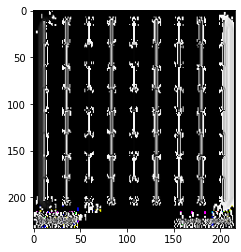

In [28]:
plt.figure()
plt.imshow(filtered_image1)

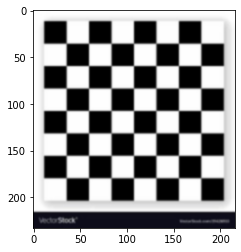

In [29]:
plt.figure()
plt.imshow(filtered_image2)

In [37]:
matrix= np.zeros([4,4])
l= 0
for i in range(4):
    for j in range(4): 
        matrix[i,j]= l
        l= l+1



vector= np.asarray(matrix).ravel()
print(vector)
len(vector)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


16